# <h1 style="font-family: Trebuchet MS; padding: 12px; font-size: 48px; color: #BA1141; text-align: center; line-height: 1.25;"><b> AYU IMAS SUSANTI <span style="color: #000000"> <br>UJIAN PRAKTIK COMPUTER VISION</span></b><br><span style="color: #FF5C8A; font-size: 24px">FIBONACCI </span></h1>
<hr>

# Text Classification (Machine Learning)


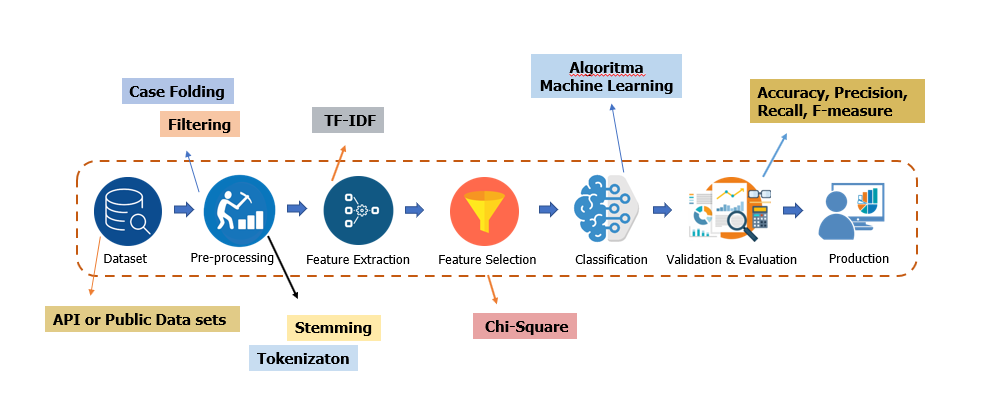

# 01 Install & Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [2]:
# Install library Sastrawi
!pip -q install sastrawi

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayuim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 02 Data Acquisition

In [4]:
!wget https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_tweet_sentiment_pilkada_DKI_2017.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
data = pd.read_csv('dataset_tweet_sentiment_pilkada_DKI_2017.csv')
data.head()

,Id,Sentiment,Pasangan Calon,Text Tweet
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              900 non-null    int64 
 1   Sentiment       900 non-null    object
 2   Pasangan Calon  900 non-null    object
 3   Text Tweet      900 non-null    object
dtypes: int64(1), object(3)
memory usage: 28.2+ KB


In [7]:
print('Total Jumlah Komentar Pasangan Calon:', data.shape[0], 'data\n')
print('terdiri dari (Sentiment):')
print('-- [0] Sentiment positive\t:', data[data.Sentiment == 'positive'].shape[0], 'data')
print('-- [1] Sentiment negative\t:', data[data.Sentiment == 'negative'].shape[0], 'data')

Total Jumlah Komentar Pasangan Calon: 900 data

terdiri dari (Sentiment):
-- [0] Sentiment positive	: 450 data
-- [1] Sentiment negative	: 450 data


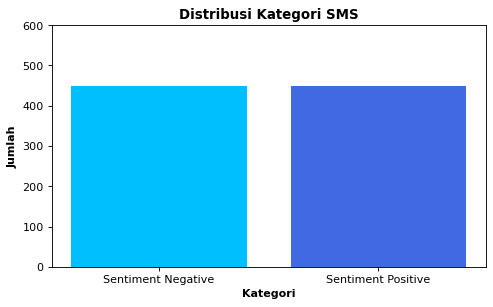

In [8]:
height = data['Sentiment'].value_counts()
labels = ('Sentiment Negative', 'Sentiment Positive')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600)
plt.title('Distribusi Kategori SMS', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue', 'skyblue'])
plt.xticks(y_pos, labels)
plt.show()

# 03 Text Preprocessing

## Case Folding

In [9]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [10]:
raw_sample = data['Text Tweet'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  aneh deh lebay masa ini di sangkut pautkan sama kandidat Calgub, anda lebay seperti yg anda dukung #agussilvy
Case folding	:  aneh deh lebay masa ini di sangkut pautkan sama kandidat calgub anda lebay seperti yg anda dukung agussilvy


## Word Normalization

In [11]:
# Download corpus kumpulan slangwords
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
key_norm = pd.read_csv('key_norm.csv')
print(key_norm.head())

key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(3720, 3)

In [13]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

## Filtering (Stopword Removal)

In [14]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [15]:
len(stopwords_ind)

758

In [16]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind[:20]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara']

In [17]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['lol', 'dammnn', 'blt']                    # Tambahkan kata lain dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [18]:
raw_sample = data['Text Tweet'].iloc[95]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  Jangan sampai SBY berkata AHY kalah gara-gara Antasari ya? Survey kan sudah menunjukan AHY terus merosot elektabilitasnya #PilkadaDKI
Case folding		:  jangan sampai sby berkata ahy kalah garagara antasari ya survey kan sudah menunjukan ahy terus merosot elektabilitasnya pilkadadki
Stopword removal	:  sby ahy kalah garagara antasari ya survey menunjukan ahy merosot elektabilitasnya pilkadadki


## Stemming

In [19]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [20]:
raw_sample = data['Text Tweet'].iloc[95]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  Jangan sampai SBY berkata AHY kalah gara-gara Antasari ya? Survey kan sudah menunjukan AHY terus merosot elektabilitasnya #PilkadaDKI
Case folding		:  jangan sampai sby berkata ahy kalah garagara antasari ya survey kan sudah menunjukan ahy terus merosot elektabilitasnya pilkadadki
Stopword removal	:  sby ahy kalah garagara antasari ya survey menunjukan ahy merosot elektabilitasnya pilkadadki
Stemming		:  sby ahy kalah garagara antasari ya survey tunjuk ahy merosot elektabilitasnya pilkadadki


## Text Preprocessing Pipeline

In [21]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [22]:
%%time
data['clean_teks'] = data['Text Tweet'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: total: 4min 4s
Wall time: 4min 9s


In [23]:
data

,Id,Sentiment,Pasangan Calon,Text Tweet,clean_teks
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...,akun kloning dukung agussilvy serang paslon an...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...,agussilvy bicara kasihan yaalap air mata wkwkwkwk
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...,sih nunggu hasil qc nunggu motif cuit sbyudhoy...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...,kasihan oh kasihan peluru milyar rw agussilvy ...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,maaf ya dukung agussilvyhayo dukung aniessandi...
...,...,...,...,...,...
895,896,positive,Anies-Sandi,"Kali saja bpk @aniesbaswedan @sandiuno lihat, ...",kali aniesbaswedan sandiuno lihat rspun selfie...
896,897,positive,Anies-Sandi,Kita harus dapat merangkul semua orang tanpa b...,rangkul orang batas usia kelamin okeoce ok han...
897,898,positive,Anies-Sandi,Ini jagoanku dibidang digital <Smiling Face Wi...,jago bidang digital smiling muka with sunglass...
898,899,positive,Anies-Sandi,#PesanBijak #OkeOce #GubernurGu3 ...,pesanbijak okeoce gubernurgu


In [24]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

# 04 Feature Engineering

In [25]:
# Pisahkan kolom fitur dan target
X = data['clean_teks']
y = data['Sentiment']

In [26]:
X

0      akun kloning dukung agussilvy serang paslon an...
1      agussilvy bicara kasihan yaalap air mata wkwkwkwk
2      sih nunggu hasil qc nunggu motif cuit sbyudhoy...
3      kasihan oh kasihan peluru milyar rw agussilvy ...
4      maaf ya dukung agussilvyhayo dukung aniessandi...
                             ...                        
895    kali aniesbaswedan sandiuno lihat rspun selfie...
896    rangkul orang batas usia kelamin okeoce ok han...
897    jago bidang digital smiling muka with sunglass...
898                         pesanbijak okeoce gubernurgu
899    sandiaga bangun rumah dp simpel banding tol ci...
Name: clean_teks, Length: 900, dtype: object

In [27]:
y

0      negative
1      negative
2      negative
3      negative
4      negative
         ...   
895    positive
896    positive
897    positive
898    positive
899    positive
Name: Sentiment, Length: 900, dtype: object

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [28]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [29]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

2620


In [30]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aa' 'aagym' 'aamiin' ... 'zarazettirazz' 'zippermouth' 'zona']


In [31]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aa,aagym,aamiin,abaaah,abal,abang,abdi,absurd,abunawas,aburizal,...,youtubebxrzdua,yra,yudhoyono,yuk,yusuf,zalim,zarazettirazr,zarazettirazz,zippermouth,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

## Feature Selection (Chi Square)

In [34]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [35]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=500) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 2620
Reduced feature number: 500


In [36]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.070075
1,0.702726
2,0.090942
3,0.319636
4,0.044793
...,...
2615,0.714585
2616,0.361920
2617,0.558453
2618,2.019580


In [37]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.070075,aa
1,0.702726,aagym
2,0.090942,aamiin
3,0.319636,abaaah
4,0.044793,abal
...,...,...
2615,0.714585,zalim
2616,0.361920,zarazettirazr
2617,0.558453,zarazettirazz
2618,2.019580,zippermouth


In [38]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
818,1.405843e+01,hand
2535,8.476888e+00,victory
1661,8.415042e+00,ok
976,6.019873e+00,jakarta
606,3.966611e+00,doa
...,...,...
984,3.139978e-05,jakartagubernurbaru
1631,8.475993e-06,nu
2323,4.822060e-06,target
906,2.679831e-07,ilc


In [39]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False,  True, False, ..., False,  True, False])

In [40]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['aagym',
 'abang',
 'agama',
 'agus',
 'agussilvy',
 'agussylvi',
 'agusyudhoyono',
 'ahoker',
 'ahokfree',
 'ahokselaludihati',
 'ahokshow',
 'ahoktakbersalah',
 'ahycenter',
 'ahydemiindonesia',
 'ahyfansclub',
 'ahyforall',
 'ahysilvy',
 'ahythenextleaderahyadalahkita',
 'ajar',
 'aji',
 'akibat',
 'akun',
 'alat',
 'amanah',
 'amanatnasional',
 'amat',
 'aneh',
 'anggap',
 'aniessandy',
 'anisa',
 'anissandi',
 'antasari',
 'apaapa',
 'apung',
 'at',
 'atas',
 'atur',
 'awas',
 'badjaberagam',
 'bagus',
 'bah',
 'bahagia',
 'bajing',
 'bakti',
 'bambangelf',
 'bangga',
 'bangsa',
 'banjir',
 'bank',
 'bapak',
 'baper',
 'barat',
 'baskoro',
 'basuki',
 'basukibtp',
 'batam',
 'bawah',
 'bayar',
 'belakang',
 'belebihan',
 'beli',
 'benci',
 'bener',
 'berani',
 'beri',
 'berita',
 'berkat',
 'betawi',
 'bidang',
 'bijaksana',
 'bikin',
 'bini',
 'blowing',
 'blunder',
 'bohong',
 'bom',
 'bosan',
 'btp',
 'buang',
 'buat',
 'bullshit',
 'bully',
 'buruk',
 'buzzer',
 'caci',
 'cag

In [41]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [42]:
kbest_feature

{'akun': 105,
 'agussilvy': 25,
 'serang': 2153,
 'kasihan': 1108,
 'cuit': 513,
 'nyungsep': 1651,
 'oh': 1658,
 'rw': 2037,
 'quickcount': 1935,
 'maaf': 1361,
 'ya': 2591,
 'aneh': 147,
 'ucap': 2493,
 'terimakasih': 2373,
 'kasih': 1107,
 'untuk': 2515,
 'agusyudhoyono': 28,
 'kalah': 1069,
 'sby': 2096,
 'tertawa': 2384,
 'survey': 2274,
 'belebihan': 323,
 'bah': 252,
 'om': 1671,
 'mulut': 1544,
 'langgar': 1287,
 'fpi': 697,
 'otomatis': 1695,
 'mas': 1416,
 'anisa': 174,
 'cinta': 489,
 'gara': 722,
 'miskin': 1507,
 'nih': 1611,
 'antasari': 181,
 'melempem': 1451,
 'modal': 1509,
 'omong': 1673,
 'gubernur': 773,
 'jatim': 1011,
 'agus': 23,
 'maju': 1372,
 'sandi': 2068,
 'gembos': 739,
 'sang': 2075,
 'gelap': 732,
 'cari': 460,
 'isu': 962,
 'video': 2536,
 'buzzer': 441,
 'awas': 230,
 'ye': 2603,
 'indonesia': 914,
 'berita': 347,
 'rizieq': 2010,
 'tanoe': 2319,
 'mayor': 1441,
 'curiga': 517,
 'buat': 416,
 'ahoker': 42,
 'bully': 425,
 'pimpin': 1842,
 'atas': 226,
 

In [43]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aagym,abang,agama,agus,agussilvy,agussylvi,agusyudhoyono,ahoker,ahokfree,ahokselaludihati,...,warta,waspada,wujud,ya,ye,youtube,yudhoyono,yuk,zalim,zippermouth
0,0.0,0.0,0.0,0.0,0.248545,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.303961,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.224008,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.216449,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.228197,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
896,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
897,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
898,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

# 05 Modelling (Machine Learning)

In [45]:
'''
Supervised learning in Sklearn
https://scikit-learn.org/stable/supervised_learning.html
'''
from sklearn.naive_bayes import MultinomialNB           # Pilih salah satu algoritma supervised learning. Contoh ini menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [46]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur

# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=40)

In [47]:
# Training the model
algorithm = MultinomialNB()               # Load algoritma pembelajaran
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model_1.joblib')

['model_1.joblib']

In [48]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array(['positive', 'negative', 'positive', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'negative', 'positive', 'negative', 'negative', 'negative',
       'negative', 'positive', 'positive', 'positive', 'negative',
       'positive', 'negative', 'negative', 'negative', 'positive',
       'positive', 'negative', 'positive', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'negative', 'positive', 'positive', 'negative', 'positive',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive',
       'positive', 'negative', 'negative', 'negative', 'negative',
       'positive', 'negative', 'positive', 'negative', 'negative',
       'negative', 'positive', 'negative', 'positive', 'positive',
       'positive', 'positive', 'negative', 'negative', 'negati

In [49]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array(['positive', 'negative', 'positive', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'negative', 'positive', 'negative', 'negative', 'negative',
       'negative', 'positive', 'positive', 'positive', 'negative',
       'positive', 'negative', 'negative', 'negative', 'positive',
       'negative', 'negative', 'positive', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'positive', 'positive', 'positive', 'positive', 'negative',
       'negative', 'positive', 'positive', 'negative', 'positive',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'positive', 'negative', 'negative', 'negative',
       'positive', 'negative', 'negative', 'negative', 'negative',
       'positive', 'negative', 'positive', 'negative', 'negative',
       'negative', 'negative', 'negative', 'positive', 'negative',
       'negative', 'negative', 'negative', 'positive', 'negati

# 06 Model Evaluation

In [50]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
sentiment_positive = (model_pred == y_test).sum()
sentiment_negative = (model_pred != y_test).sum()

print('Jumlah sentiment positive\t:', sentiment_positive)
print('Jumlah sentiment negative\t:', sentiment_negative)

accuracy = sentiment_positive / (sentiment_positive + sentiment_negative)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah sentiment positive	: 153
Jumlah sentiment negative	: 27
Akurasi pengujian	: 85.0 %


In [51]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[71 24]
 [ 3 82]]


In [52]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

    negative       0.96      0.75      0.84        95
    positive       0.77      0.96      0.86        85

    accuracy                           0.85       180
   macro avg       0.87      0.86      0.85       180
weighted avg       0.87      0.85      0.85       180



In [53]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.77222222 0.86666667 0.81666667 0.85555556 0.83888889 0.81666667
 0.85555556 0.85       0.81666667 0.81111111] 

Rata-rata akurasi pada cross validation: 0.8299999999999998
